In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split

import cv2

import numpy as np

from matplotlib import pyplot as plt

import os
import shutil

print(tf.__version__)
print(tf.config.list_physical_devices())

2.8.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
class blocc(layers.Layer):
    def __init__(self, filters, k_size, stride = 1, pad = 0, activation = layers.LeakyReLU()):
        super().__init__()
        self.pad = pad
        self.conv1 = layers.Conv2D(filters, kernel_size = k_size, strides = stride, padding = 'valid')
        self.activation = activation
        self.batchNorm = layers.BatchNormalization()

    def call(self, input_tensor, training = False):
        input = input_tensor
        if self.pad != 0:
            input = tf.pad(input, [[0, 0], [self.pad, self.pad], [self.pad, self.pad], [0, 0]], 'constant')

        x = self.conv1(input)
        x = self.batchNorm(x, training = training)
        return self.activation(x)

class simplebloc(layers.Layer):
    def __init__(self, out1, out3, activation = layers.LeakyReLU()):
        super().__init__()

        self.conv1 = blocc(out1, 1, pad = 0, activation = activation)
        self.conv2 = blocc(out3, 3, pad = 1, activation = activation)

    def call(self, input):
        conv1_out = self.conv1(input)
        conv2_out = self.conv2(input)

        output = tf.concat(values = [conv1_out, conv2_out], axis = 3)
        return output

class full_model(keras.Model):
    def __init__(self, in_channels = 3, out_channels = 1):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.activation = layers.LeakyReLU(0.01)
        self.final_activation = layers.LeakyReLU(0.01)
        self.patch_size = 32

        self.conv1 = blocc(64, 3, pad = self.patch_size, activation = self.activation)
        self.simple1 = simplebloc(16, 16, activation = self.activation)
        self.simple2 = simplebloc(16, 32, activation = self.activation)
        self.conv2 = blocc(16, 14, activation = self.activation)
        self.simple3 = simplebloc(112, 48, activation=self.activation)
        self.simple4 = simplebloc(64, 32, activation=self.activation)
        self.simple5 = simplebloc(40, 40, activation=self.activation)
        self.simple6 = simplebloc(32, 96, activation=self.activation)
        self.conv3 = blocc(32, 18, activation=self.activation)
        self.conv4 = blocc(64, 1, activation=self.activation)
        self.conv5 = blocc(64, 1, activation=self.activation)

        self.conv6 = blocc(1, 1, activation = self.final_activation)

    def call(self, input):
        x = self.conv1(input)
        x = self.simple1(x)
        x = self.simple2(x)
        x = self.conv2(x)
        x = self.simple3(x)
        x = self.simple4(x)
        x = self.simple5(x)
        x = self.simple6(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        return x

In [3]:
def load_data():
    notation_path = '../mbm_data/labels'
    image_path = '../mbm_data/image'
    notations = []
    images = []

    dot_list = os.listdir(notation_path)
    image_list = os.listdir(image_path)

    for entry in dot_list:
        img = cv2.imread(os.path.join(notation_path, entry))
        # Insert any image preprocessing here!
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = np.float32(img)
        img = img[..., np.newaxis]
        
        
        notations.append(img)

    for entry in image_list:
        img = cv2.imread(os.path.join(image_path, entry))

        # Insert any image preprocessing here! TODO

        images.append(img)

    return np.array(images), np.array(notations)

def make_labels(debug = False):
    file_path = '../mbm_data'
    dir_name = 'labels'
    dot_path = '../mbm_data/notation'

    cur_dir = os.getcwd()
    label_maker = layers.Conv2D(1, 32, padding='same', use_bias=False, kernel_initializer='Ones')
    ret = []
    notations = []

    dot_list = os.listdir(dot_path)

    for entry in dot_list:
        img = cv2.imread(os.path.join(dot_path, entry))

        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.normalize(img, None, 0, 1, cv2.NORM_MINMAX)
        img = np.float32(img)
        img = img[..., np.newaxis]
        notations.append(img)

    notations = np.array(notations)
    pads = tf.pad(notations, [[0, 0], [16, 16], [16, 16], [0, 0]], 'constant')
    heat = label_maker(pads)
    heat = heat.numpy()

    if debug:
        return heat

    direct_path = os.path.join(file_path, dir_name)
    if os.path.exists(direct_path):
        shutil.rmtree(direct_path)

    os.mkdir(direct_path)
    
    os.chdir(direct_path)
    for i, img in enumerate(heat):
        img_save = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
        cv2.imwrite('map' + dot_list[i], img_save)

    os.chdir(cur_dir)

In [4]:
# h = make_labels()

In [5]:
random_seed = 56
x, y = load_data()

In [6]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.15, random_state=random_seed
)

x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.15, random_state=random_seed
)

x = np.float32(x)
x_train = np.float32(x_train)
x_test = np.float32(x_test)
x_val = np.float32(x_val)

In [7]:
print('-----raw-----')
print('X: ', x.shape)
print('Y: ', y.shape)

print('-----Parameters-----')
print('Training: ', x_train.shape)
print('Test: ', x_test.shape)
print('Validation: ', x_val.shape)

print('-----Labels-----')
print('Training: ', y_train.shape)
print('Test: ', y_test.shape)
print('Validation: ', y_val.shape)

-----raw-----
X:  (44, 600, 600, 3)
Y:  (44, 632, 632, 1)
-----Parameters-----
Training:  (31, 600, 600, 3)
Test:  (7, 600, 600, 3)
Validation:  (6, 600, 600, 3)
-----Labels-----
Training:  (31, 632, 632, 1)
Test:  (7, 632, 632, 1)
Validation:  (6, 632, 632, 1)


In [8]:
np.save('./data/x_raw.npy', x)
np.save('./data/y_raw.npy', y)
np.save('./data/x_train.npy', x_train)
np.save('./data/y_train.npy', y_train)
np.save('./data/x_test.npy', x_test)
np.save('./data/y_test.npy', y_test)
np.save('./data/x_val.npy', x_val)
np.save('./data/y_val.npy', y_val)

### Loss: MAE/MSE
### Optimizer: Adam
### Epochs: 15
### Batches: TBD

In [8]:
print(tf.test.is_built_with_cuda())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

True
Num GPUs Available:  1


In [9]:
lr = 0.001
epochs = 15
batch = 1

#loss = keras.losses.mean_absolute_error()
opt = keras.optimizers.Adam(learning_rate=lr)

model = full_model()

model.compile(optimizer=opt, loss='mean_absolute_error', metrics=['Accuracy'])

In [10]:
shape = x_test.shape
model.build(input_shape=shape)
model.summary()

Model: "full_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 leaky_re_lu_2 (LeakyReLU)   multiple                  0         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   multiple                  0         
                                                                 
 blocc (blocc)               multiple                  2048      
                                                                 
 simplebloc (simplebloc)     multiple                  10400     
                                                                 
 simplebloc_1 (simplebloc)   multiple                  9968      
                                                                 
 blocc_5 (blocc)             multiple                  150608    
                                                                 
 simplebloc_2 (simplebloc)   multiple                  9

In [ ]:
model.fit(x_train, y_train, epochs=epochs, batch_size=batch, validation_data=(x_val, y_val))

In [3]:

model = keras.models.load_model('./prelim')

In [57]:
pp = cv2.imread('./not1.png')
not_pp = cv2.imread('./notation.png')
not_shp = cv2.cvtColor(not_pp, cv2.COLOR_BGR2GRAY)
not_shp = np.float32(not_shp)
not_shp = cv2.normalize(not_shp, None, 0, 1, cv2.NORM_MINMAX)
not_shp = not_shp[np.newaxis, ..., np.newaxis]


shp = np.float32(pp)
shp = shp[np.newaxis]
shp.shape

(1, 600, 600, 3)

In [1]:
ppp = model.predict(shp)
lay = layers.Conv2D(1, 32, padding='same', use_bias=False, kernel_initializer='Ones')

label_image = lay(not_shp)
label_image = label_image[0]

ppp.shape

NameError: name 'model' is not defined

In [59]:
pixels = {}
for row in np.array(label_image):
    for val in row:
        if val[0] not in pixels:
            pixels[val[0]] = 1

        else:
            pixels[val[0]] += 1

pixels

{0.0: 297088, 1.0: 56238, 2.0: 6500, 3.0: 174}

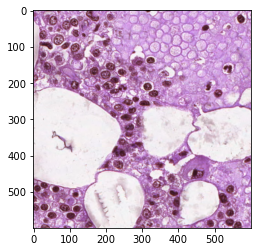

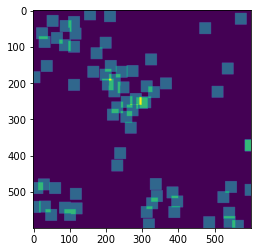

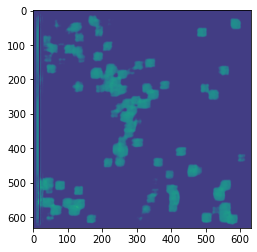

In [60]:
plt.imshow(pp)
plt.show()

plt.imshow(label_image)
plt.show()

plt.imshow(ppp[0])
plt.show()

In [62]:
image = np.array(label_image)

biggest = 0
smallest = 10

for row in image:
    for val in row:
        biggest = max(val[0], biggest)
        smallest = min(val[0], smallest)



In [63]:
print(biggest)
print(smallest)

3.0
0.0


{0.0: 297088, 765.0: 56238, 1530.0: 6500, 2295.0: 174}